In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [3]:
token_level_result = pd.read_csv(
    "iter_level/iter_result_diff_prefill_bs_compare_swap_policy.csv"
)

output_dir = "./fig"

In [4]:
token_level_result.columns

Index(['request_round', 'latency', 'request_num_each_round', 'num_tokens',
       'token_chunk_size', 'num_running_to_waiting', 'num_waiting_to_running',
       'recomputed_token_nums', 'prefill_token_num_each_request', 'cvs',
       'current_stage', 'wasted_block_sizes', 'total_block_sizes',
       'throughput', 'batch_size', 'request_num', 'random_seed', 'strategy',
       'enable_chunk_prefill', 'policy', 'repeat_time', 'max_token_num',
       'prefill_mode'],
      dtype='object')

In [4]:
token_vertical_prefill_latency = (
    token_level_result[
        (token_level_result["current_stage"] == "prefill")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        & (token_level_result["prefill_mode"] == "vertical")
    ][["latency", "num_tokens","batch_size"]]
    .groupby(["num_tokens","batch_size"])
    .mean()
    .reset_index()
)

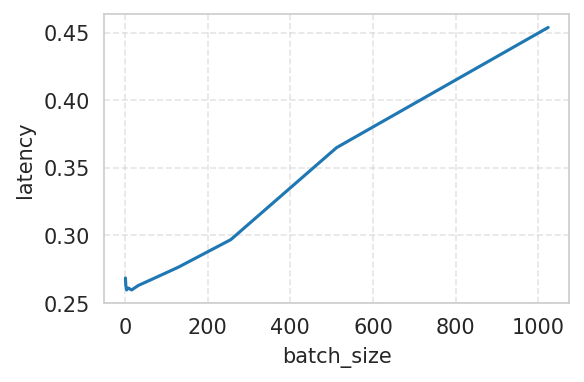

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(4, 2.5), dpi=150)
sns.lineplot(
    data=token_vertical_prefill_latency[
        token_vertical_prefill_latency["batch_size"] <=2048
    ],
    x="batch_size",
    y="latency",
)
plt.grid(alpha=0.5, linestyle="--")
# plt.xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rotation=90)
# plt.xscale("log")

In [4]:
token_vertical_prefill_latency = (
    token_level_result[
        (token_level_result["current_stage"] == "prefill")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        & (token_level_result["prefill_mode"] == "vertical")
    ][["latency", "num_tokens","bacth_size"]]
    .groupby(["num_tokens","batch_size"])
    .mean()
    .reset_index()
)
token_prefill_latency = (
    token_level_result[
        (token_level_result["current_stage"] == "prefill")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        & (token_level_result["prefill_mode"] == "horizonal")
    ][["latency", "num_tokens"]]
    .groupby(["num_tokens"])
    .mean()
    .reset_index()
)
token_decode_latency = (
    token_level_result[
        (token_level_result["current_stage"] == "decode")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        & (token_level_result["prefill_mode"] == "vertical")
    ][["latency", "num_tokens"]]
    .groupby(["num_tokens"])
    .mean()
    .reset_index()
)

# token_hybrid_latency = (
#     token_level_result[
#         (token_level_result["current_stage"] == "hybrid")
#         & (token_level_result["strategy"] == "hybrid")
#         & (token_level_result["repeat_time"] > 0)
#     ][["latency", "num_tokens"]]
#     .groupby(["num_tokens"])
#     .mean()
#     .reset_index()
# )


token_prefill_decode_latency_compare = token_prefill_latency.merge(
    token_decode_latency,
    on=["num_tokens"],
    suffixes=("_prefill", "_decode"),
)
token_prefill_decode_latency_compare = (
    token_prefill_decode_latency_compare.merge(
        token_vertical_prefill_latency,
        on=["num_tokens"],
        suffixes=("", "_vertical"),
    )
)

token_prefill_decode_latency_compare["latency_diff"] = (
    token_prefill_decode_latency_compare["latency_prefill"]
    - token_prefill_decode_latency_compare["latency_decode"]
)
token_prefill_decode_latency_compare["latency_diff_ratio"] = (
    token_prefill_decode_latency_compare["latency_diff"]
    / token_prefill_decode_latency_compare["latency_prefill"]
)
# token_prefill_decode_latency_compare = (
#     token_prefill_decode_latency_compare.merge(
#         token_hybrid_latency, on=["num_tokens"]
#     )
# )

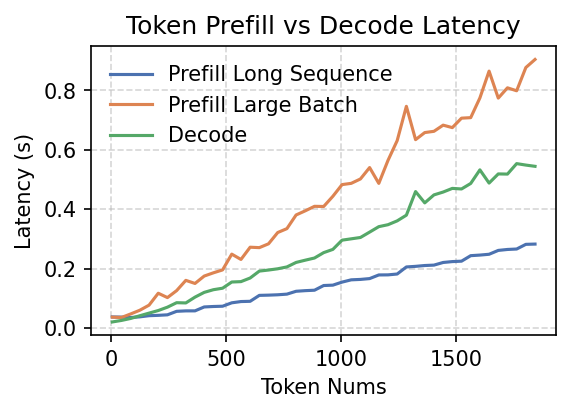

In [5]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
sns.lineplot(
    data=token_prefill_decode_latency_compare,
    x="num_tokens",
    y="latency_prefill",
    label="Prefill Long Sequence",
    color=colors[0],
)
sns.lineplot(
    data=token_prefill_decode_latency_compare,
    x="num_tokens",
    y="latency",
    label="Prefill Large Batch",
    color=colors[1],
)
sns.lineplot(
    data=token_prefill_decode_latency_compare,
    x="num_tokens",
    y="latency_decode",
    label="Decode",
    color=colors[2],
)
# sns.lineplot(
#     data=token_prefill_decode_latency_compare,
#     x="num_tokens",
#     y="latency",
#     label="Hybrid",
#     color=colors[2],
# )
plt.legend(frameon=False)
plt.xlabel("Token Nums")
plt.ylabel("Latency (s)")
plt.title("Token Prefill vs Decode Latency")
plt.grid(alpha=0.5, linestyle="--")
# plt.show()
# plt.savefig(f"{output_dir}/token_prefill_decode_time.pdf", bbox_inches="tight")

In [32]:
decode_coefficient = np.polyfit(
    x=token_prefill_decode_latency_compare["num_tokens"],
    y=token_prefill_decode_latency_compare["latency_decode"],
    deg=1,
)
prefill_coefficient = np.polyfit(
    x=token_prefill_decode_latency_compare["num_tokens"],
    y=token_prefill_decode_latency_compare["latency_prefill"],
    deg=1,
)
# hybrid_coefficient = np.polyfit(
#     x=token_prefill_decode_latency_compare["num_tokens"],
#     y=token_prefill_decode_latency_compare["latency"],
#     deg=1,
# )

In [27]:
print("Prefill Coefficient: ", prefill_coefficient)
print("Decode Coefficient: ", decode_coefficient)
# print("Hybrid Coefficient: ", hybrid_coefficient)

Prefill Coefficient:  [ 0.00044243 -0.0025231 ]
Decode Coefficient:  [ 0.00030538 -0.0038178 ]


In [42]:
token_prefill_tp = (
    token_level_result[
        (token_level_result["current_stage"] == "prefill")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        # & (token_level_result["prefill_mode"] == "horizonal")
    ][["throughput", "num_tokens"]]
    .groupby(["num_tokens"])
    .mean()
    .reset_index()
)
token_decode_tp = (
    token_level_result[
        (token_level_result["current_stage"] == "decode")
        & (token_level_result["strategy"] == "full")
        & (token_level_result["repeat_time"] > 0)
        # & (token_level_result["prefill_mode"] == "vertical")
    ][["throughput", "num_tokens"]]
    .groupby(["num_tokens"])
    .mean()
    .reset_index()
)

# token_hybrid_tp = (
#     token_level_result[token_level_result["current_stage"] == "hybrid"][
#         ["throughput", "num_tokens"]
#     ]
#     .groupby(["num_tokens"])
#     .mean()
#     .reset_index()
# )


token_prefill_decode_tp_compare = token_prefill_tp.merge(
    token_decode_tp,
    on=["num_tokens"],
    suffixes=("_prefill", "_decode"),
)
token_prefill_decode_tp_compare["throughput_diff"] = (
    token_prefill_decode_tp_compare["throughput_prefill"]
    - token_prefill_decode_tp_compare["throughput_decode"]
)
token_prefill_decode_tp_compare["throughput_diff_ratio"] = (
    token_prefill_decode_tp_compare["throughput_diff"]
    / token_prefill_decode_tp_compare["throughput_prefill"]
)
# token_prefill_decode_tp_compare=token_prefill_decode_tp_compare.merge(
#     token_hybrid_tp,
#     on=["num_tokens"],
# )

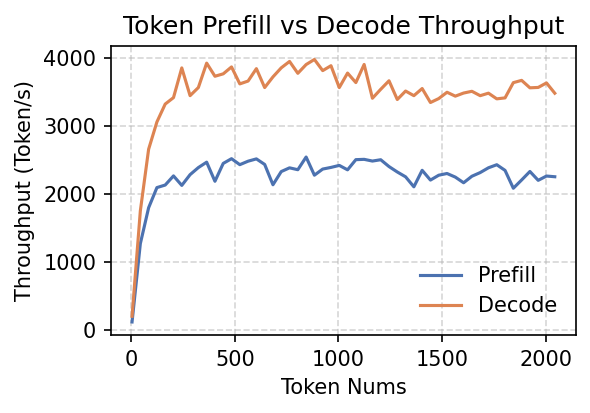

In [43]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
sns.lineplot(
    data=token_prefill_decode_tp_compare,
    x="num_tokens",
    y="throughput_prefill",
    label="Prefill",
    color=colors[0],
)
sns.lineplot(
    data=token_prefill_decode_tp_compare,
    x="num_tokens",
    y="throughput_decode",
    label="Decode",
    color=colors[1],
)
# sns.lineplot(
#     data=token_prefill_decode_tp_compare,
#     x="num_tokens",
#     y="throughput",
#     label="Hybrid",
#     color=colors[2],
# )
plt.legend(frameon=False)
plt.xlabel("Token Nums")
plt.ylabel("Throughput (Token/s)")
plt.title("Token Prefill vs Decode Throughput")
plt.grid(alpha=0.5, linestyle="--")